<h4><strong>Problem Statement</strong></h4>
<p>Conshohocken Insurance Company (CIC) buys approximately 5,000 leads per month.  These leads represent individual consumer interactions with web forms that exist on Publisher websites, where the consumer supplies their contact information and additional data about themselves.  CIC can purchase this information from lead Providers which it can then use to contact and attempt to sell insurance policies to these consumers. CIC’s goal is to identify which leads to purchase from which Provider so as to minimize overall lead spend while maximizing average customer lifetime value (LTV) of each purchased lead.  To accomplish this, they need a model that takes lead event attributes as inputs and accurately predicts LTV for new leads</p>
<p>Include the following attributes: Provider, State, LeadAge, LeadDuration, total_hops, total_entities, ip_frequency, consumer_frequency, device, field_count, pct_fields_changed and CallCenter (do not use Cost attribute)</p>
<h5><strong>Definition of Insurance LTV:<strong></h5>
<p>Customer lifetime value (CLV) is the “discounted value of future profits generated by a customer." The word "profits" here includes costs and revenue estimates, as both metrics are very important in estimating true CLV; however, the focus of many CLV models is on the revenue side. The reason for this is that revenue is more difficult to forecast than cost, so a model is more necessary to predict it (and knowing the revenue a customer will generate can inform your spend on that customer). These types of models are often called "customer equity models." </p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBRFRegressor, plot_importance

pd.set_option('display.max_columns', None)

<h5><strong>Binary encode States to minimize column bloat (easier done manually in this case)</strong></h5>
<p>will need 6 columns to binary encode states</p>

In [2]:
states = ["AK","AL","AR","AZ","CA","CO","CT","DC","DE","FL","GA","GU","HI","IA","ID", "IL","IN","KS","KY","LA","MA","MD","ME","MH","MI","MN","MO","MS","MT","NC","ND","NE",
         "NH","NJ","NM","NV","NY", "OH","OK","OR","PA","PR","PW","RI","SC","SD","TN","TX","UT","VA","VI","VT","WA","WI","WV","WY","ON","None"]
index = 0
state_dict = {}
for state in states:
    state_dict[states[index]] = '{0:06b}'.format(index)
    index += 1
print(state_dict)

{'AK': '000000', 'AL': '000001', 'AR': '000010', 'AZ': '000011', 'CA': '000100', 'CO': '000101', 'CT': '000110', 'DC': '000111', 'DE': '001000', 'FL': '001001', 'GA': '001010', 'GU': '001011', 'HI': '001100', 'IA': '001101', 'ID': '001110', 'IL': '001111', 'IN': '010000', 'KS': '010001', 'KY': '010010', 'LA': '010011', 'MA': '010100', 'MD': '010101', 'ME': '010110', 'MH': '010111', 'MI': '011000', 'MN': '011001', 'MO': '011010', 'MS': '011011', 'MT': '011100', 'NC': '011101', 'ND': '011110', 'NE': '011111', 'NH': '100000', 'NJ': '100001', 'NM': '100010', 'NV': '100011', 'NY': '100100', 'OH': '100101', 'OK': '100110', 'OR': '100111', 'PA': '101000', 'PR': '101001', 'PW': '101010', 'RI': '101011', 'SC': '101100', 'SD': '101101', 'TN': '101110', 'TX': '101111', 'UT': '110000', 'VA': '110001', 'VI': '110010', 'VT': '110011', 'WA': '110100', 'WI': '110101', 'WV': '110110', 'WY': '110111', 'ON': '111000', 'None': '111001'}


<h5><strong>Read in test/train and blind data - then preprocess<strong></h5>
<ol>
<li>scale continuous data as appropriate
<li>binary encode states and one hot encode devices and providers
</ol>

In [3]:
raw_train = pd.read_csv('CIC LTV data.csv')
raw_train.head()

,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter,LTV
0,3,A,95,OH,48,510,1,1,95,0,android,115,0.16,1,-37
1,4,C,60,CA,195,146,0,2,0,0,iphone,163,0.15,0,-61
2,5,B,80,MO,1,146,1,2,44,0,iphone,127,0.86,0,23
3,6,A,95,TN,268,98,1,1,0,0,iphone,35,0.90,0,7
4,7,B,80,TN,129,302,1,1,96,0,iphone,29,0.12,1,118


In [4]:
raw_blind = pd.read_csv('CIC LTV blind data.csv')
raw_blind.head()

,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter
0,1,B,80,IL,205,657,0,2,17,0,android,56,0.67,1
1,2,C,60,IL,150,179,0,1,0,0,android,10,0.38,0
2,9,B,80,OH,211,580,0,1,0,0,iphone,104,0.51,0
3,11,C,60,NY,50,116982,0,1,5,2,android,43,0.54,0
4,12,B,80,NY,37,116,1,1,4,0,android,97,0.38,0


<p>Add binary encoded columns state categories

In [5]:
# training data
train_data = raw_train.copy(deep=True)
train_data['State'].fillna('None', inplace=True)
st = train_data['State'].tolist()
# print(st)
s5 = [int(state_dict[s][0]) for s in st]
s4 = [int(state_dict[s][1]) for s in st]
s3 = [int(state_dict[s][2]) for s in st]
s2 = [int(state_dict[s][3]) for s in st]
s1 = [int(state_dict[s][4]) for s in st]
s0 = [int(state_dict[s][5]) for s in st]
train_data['State_b5'] = s5
train_data['State_b4'] = s4
train_data['State_b3'] = s3
train_data['State_b2'] = s2
train_data['State_b1'] = s1
train_data['State_b0'] = s0
del train_data['State']

# blind data
blind_data = raw_blind.copy(deep=True)
blind_data['State'].fillna('None', inplace=True)
st = blind_data['State'].tolist()
# print(st)
s5 = [int(state_dict[s][0]) for s in st]
s4 = [int(state_dict[s][1]) for s in st]
s3 = [int(state_dict[s][2]) for s in st]
s2 = [int(state_dict[s][3]) for s in st]
s1 = [int(state_dict[s][4]) for s in st]
s0 = [int(state_dict[s][5]) for s in st]
blind_data['State_b5'] = s5
blind_data['State_b4'] = s4
blind_data['State_b3'] = s3
blind_data['State_b2'] = s2
blind_data['State_b1'] = s1
blind_data['State_b0'] = s0
del blind_data['State']

<p>Add one hot encoded columns provider categories

In [6]:
# training data
train_data['Prov_A'] = np.where(train_data['Provider']=='A', 1, 0)
train_data['Prov_B'] = np.where(train_data['Provider']=='B', 1, 0)
train_data['Prov_C'] = np.where(train_data['Provider']=='C', 1, 0)
train_data['Prov_D'] = np.where(train_data['Provider']=='D', 1, 0)
train_data['Prov_E'] = np.where(train_data['Provider']=='E', 1, 0)
del train_data['Provider']

# blind data
blind_data['Prov_A'] = np.where(blind_data['Provider']=='A', 1, 0)
blind_data['Prov_B'] = np.where(blind_data['Provider']=='B', 1, 0)
blind_data['Prov_C'] = np.where(blind_data['Provider']=='C', 1, 0)
blind_data['Prov_D'] = np.where(blind_data['Provider']=='D', 1, 0)
blind_data['Prov_E'] = np.where(blind_data['Provider']=='E', 1, 0)
del blind_data['Provider']

<p>Add one hot encoded columns device categories

In [7]:
# training data
train_data['dev_and'] = np.where(train_data['device']=='android', 1, 0)
train_data['dev_iph'] = np.where(train_data['device']=='iphone', 1, 0)
train_data['dev_blc'] = np.where(train_data['device']=='blackberry', 1, 0)
del train_data['device']
del train_data['LeadiD']

# blind data
blind_data['dev_and'] = np.where(blind_data['device']=='android', 1, 0)
blind_data['dev_iph'] = np.where(blind_data['device']=='iphone', 1, 0)
blind_data['dev_blc'] = np.where(blind_data['device']=='blackberry', 1, 0)
del blind_data['device']
del blind_data['LeadiD']

<p>Use Scikits StandardScaler to normalize data

In [8]:
# training data
cols_to_norm = ['LeadAge', 'LeadDuration', 'total_hops', 'total_entities', 'ip_frequency', 'consumer_frequency', 'field_count', 'pct_fields_changed']
train_data[cols_to_norm] = train_data[cols_to_norm].astype(float)
train_data[cols_to_norm] = StandardScaler().fit_transform(train_data[cols_to_norm])

# blind data
blind_data[cols_to_norm] = blind_data[cols_to_norm].astype(float)
blind_data[cols_to_norm] = StandardScaler().fit_transform(blind_data[cols_to_norm])

In [9]:
del train_data['Cost']
train_data.head(10)

,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,field_count,pct_fields_changed,CallCenter,LTV,State_b5,State_b4,State_b3,State_b2,State_b1,State_b0,Prov_A,Prov_B,Prov_C,Prov_D,Prov_E,dev_and,dev_iph,dev_blc
0,-0.999766,-0.051650,0.345774,-0.561266,0.015869,-0.368139,0.176351,-1.202714,1,-37,1,0,0,1,0,1,1,0,0,0,0,1,0,0
1,0.953852,-0.065193,-1.065063,0.883506,-0.074166,-0.368139,0.418254,-1.237618,0,-61,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,-1.624393,-0.065193,0.345774,0.883506,-0.032465,-0.368139,0.236826,1.240592,0,23,0,1,1,0,1,0,0,1,0,0,0,0,1,0
3,1.924016,-0.066979,0.345774,-0.561266,-0.074166,-0.368139,-0.226821,1.380210,0,7,1,0,1,1,1,0,1,0,0,0,0,0,1,0
4,0.076717,-0.059389,0.345774,-0.561266,0.016817,-0.368139,-0.257059,-1.342331,1,118,1,0,1,1,1,0,0,1,0,0,0,0,1,0
5,-0.547909,-0.049045,1.756611,0.883506,-0.074166,-0.368139,0.120915,0.682122,0,26,1,0,0,1,0,1,1,0,0,0,0,0,1,0
6,1.139911,-0.045734,0.345774,-0.561266,-0.049525,2.449926,-0.151226,-0.504626,1,16,1,0,0,1,0,0,0,0,1,0,0,0,1,0
7,-1.026346,-0.026534,1.756611,0.883506,-0.061846,1.745409,-0.151226,-0.015965,0,91,0,0,1,1,1,0,0,1,0,0,0,0,1,0
8,0.063427,-0.063519,0.345774,-0.561266,0.018713,0.336377,-0.161306,-0.644244,1,67,0,0,1,0,1,0,1,0,0,0,0,0,1,0
9,-0.454880,-0.039966,-1.065063,0.883506,-0.026779,0.336377,-0.211702,1.066070,1,-56,0,1,1,0,1,0,1,0,0,0,0,1,0,0


In [10]:
del blind_data['Cost']
blind_data.head(10)

,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,field_count,pct_fields_changed,CallCenter,State_b5,State_b4,State_b3,State_b2,State_b1,State_b0,Prov_A,Prov_B,Prov_C,Prov_D,Prov_E,dev_and,dev_iph,dev_blc
0,1.082203,-0.063020,-1.064459,0.922098,-0.063061,-0.374038,-0.125847,0.570693,1,0,0,1,1,1,1,0,1,0,0,0,1,0,0
1,0.356886,-0.090164,-1.064459,-0.551419,-0.078756,-0.374038,-0.310365,-0.430565,0,0,0,1,1,1,1,0,0,1,0,0,1,0,0
2,1.161329,-0.067392,-1.064459,-0.551419,-0.078756,-0.374038,0.066695,0.018275,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0
3,-0.961873,6.542649,-1.064459,-0.551419,-0.074140,1.090550,-0.177993,0.121853,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
4,-1.133312,-0.093741,0.362388,-0.551419,-0.075063,-0.374038,0.038616,-0.430565,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
5,1.359143,-0.033037,-1.064459,0.922098,-0.078756,1.822843,0.098785,1.123110,0,1,1,1,0,0,1,0,0,1,0,0,1,0,0
6,-0.091492,-0.033037,0.362388,-0.551419,-0.075063,1.090550,-0.298331,1.054058,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
7,-0.342057,-0.086757,0.362388,-0.551419,-0.067677,1.822843,0.183022,-0.913930,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0
8,-0.777247,-0.072901,0.362388,-0.551419,-0.051060,-0.374038,0.170988,0.846901,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0
9,-0.447557,-0.086586,-1.064459,-0.551419,-0.078756,0.358256,-0.198050,0.259958,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0


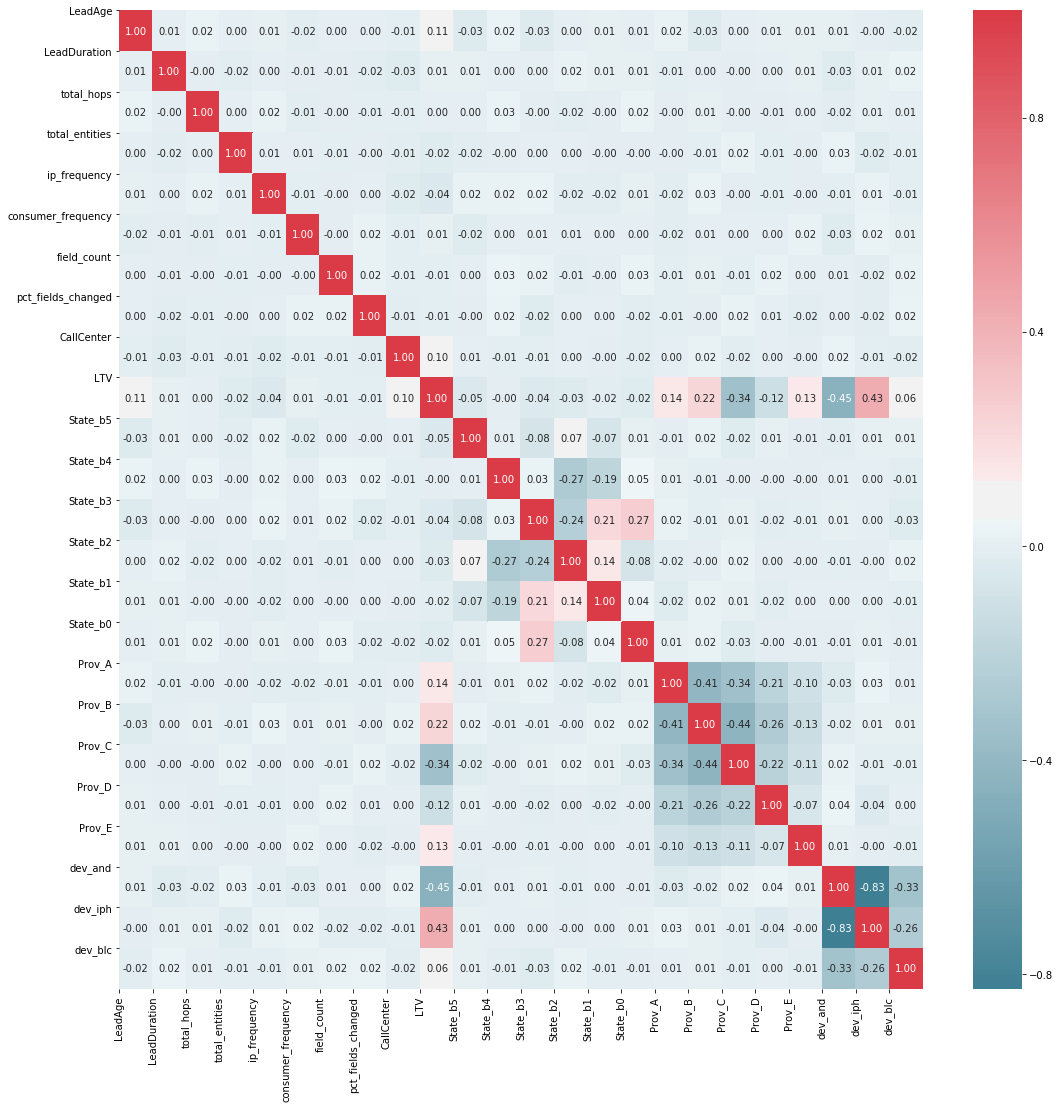

In [11]:
#Create Correlation data
corr = train_data.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(18, 18))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

<p>Make train/test split on train_data

In [12]:
y = train_data.LTV
del train_data['LTV']
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42)

<h4><strong>Apply Tree-based ML:</strong></h4>
<ol>
    <li><h5> XGBoost regression</h5>
    <li><h5> XGBoost Random Forest regression (new in XGBoost v0.9.0 - not well documented)</h5>
    <li><h5> Scikits Learn Random Forest regression</h5>
</ol>

In [13]:
x = XGBRegressor(random_state = 44, n_jobs = 8, n_estimators = 10000, max_depth=10, verbosity = 0)
x.fit(X_train, y_train)
print('R2 train score: {0:.2f}'.format(x.score(X_train, y_train)))
predictions = x.predict(X_test)
LTV_predict_of = x.predict(train_data)
print('R2 test score: {0:.2f}'.format(x.score(X_test, y_test)))

C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R2 train score: 1.00
R2 test score: 0.87


In [14]:
xrf = XGBRFRegressor(random_state = 44, n_jobs = 8, n_estimators = 10000, max_depth=10, verbosity = 0)
xrf.fit(X_train, y_train)
print('R2 train score: {0:.2f}'.format(xrf.score(X_train, y_train)))
predictions = xrf.predict(X_test)
print('R2 test score: {0:.2f}'.format(xrf.score(X_test, y_test)))

C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R2 train score: 0.90
R2 test score: 0.84


In [15]:
rf = RandomForestRegressor(n_estimators = 100, criterion='mse', verbose=0, random_state = np.random.RandomState(42), n_jobs = -1)
# Train the model on training data
rf.fit(X_train, y_train);
print('R2 train score: {0:.2f}'.format(rf.score(X_train, y_train)))
predictions = rf.predict(X_test)
print('R2 test score: {0:.2f}'.format(rf.score(X_test, y_test)))

R2 train score: 0.98
R2 test score: 0.87


<h5><strong>Test/Train RMSE and MAE for XGB Regressor (with initial parameters)</strong></h5>

C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R2 train score: 1.00
R2 test score: 0.87


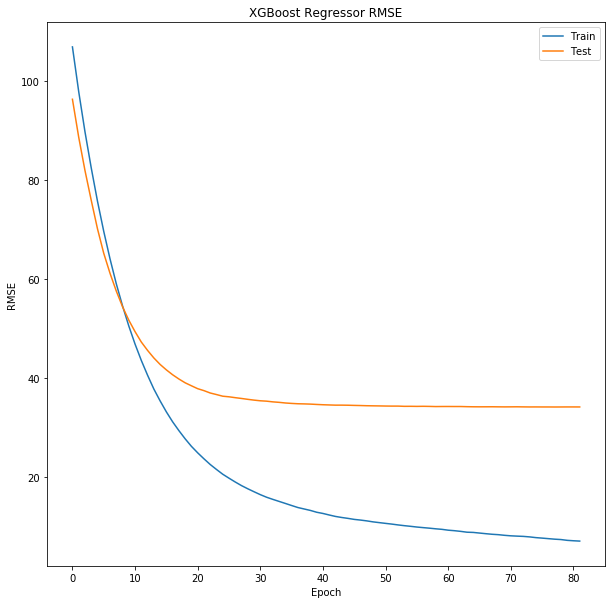

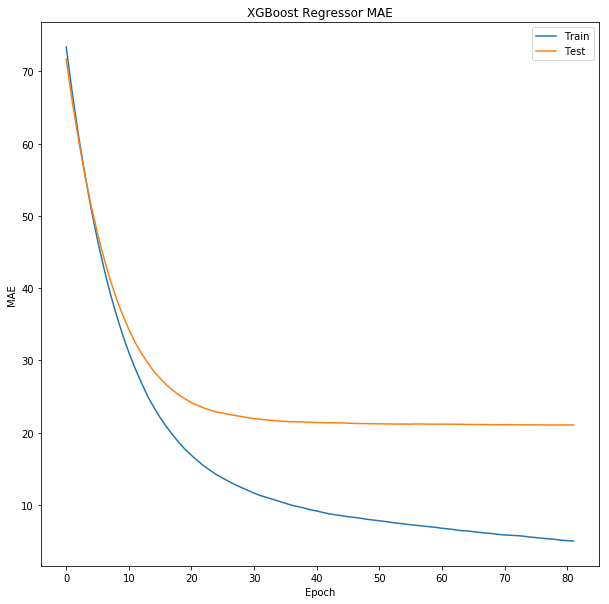

In [16]:
x = XGBRegressor(random_state = 44, n_jobs = 8, n_estimators = 10000, max_depth=10, verbosity = 0)
eval_set = [(X_train, y_train), (X_test, y_test)]
x.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=eval_set, verbose=False, early_stopping_rounds=5)
print('R2 train score: {0:.2f}'.format(x.score(X_train, y_train)))
predictions = x.predict(X_test)
print('R2 test score: {0:.2f}'.format(x.score(X_test, y_test)))
results = x.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('XGBoost Regressor RMSE')
plt.show()
# plot mae
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('XGBoost Regressor MAE')
plt.show()

<h4><strong>All models are overfitting - tuning parameters to reduce overfit</strong></h4>
<h5><strong>XGB Regression is the best "overfitter" out-of-the-box</strong></h5>
<ol>
    <li><h5>The number and size of trees (n_estimators and max_depth)</h5>
    <li><h5>The learning rate</h5>
    <li><h5>L1 (analogous to Lasso regression) and L2 (analogous to Ridge regression) regularization terms</h5>
</ol>

In [17]:
n_estimators = [200, 210, 220]
max_depth = [2, 3, 4]
learning_rate = [0.1, 0.15, 0.2]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, objective=['reg:squarederror'])

xgb = XGBRegressor()

kfold = KFold(n_splits=4, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, return_train_score=True)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print('Best: {:.2f} using {} \n '.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{:.2f} ({:.2f}) with: {}".format(mean, stdev, param))

C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Best: -962.43 using {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror'} 
 
-1001.81 (174.86) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'objective': 'reg:squarederror'}
-991.21 (173.32) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror'}
-983.56 (171.82) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 220, 'objective': 'reg:squarederror'}
-1079.67 (249.99) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror'}
-1080.19 (253.45) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 210, 'objective': 'reg:squarederror'}
-1081.99 (251.17) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 220, 'objective': 'reg:squarederror'}
-1139.06 (431.28) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'reg:squarederror'}
-1142.92 (430.35) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_

In [18]:
x = XGBRegressor(random_state = 44, n_jobs = 8, n_estimators = 210, max_depth=2, learning_rate=0.15, verbosity = 0)
x.fit(X_train, y_train)
print('R2 train score: {0:.2f}'.format(x.score(X_train, y_train)))
predictions = x.predict(X_test)
print('R2 test score: {0:.2f}'.format(x.score(X_test, y_test)))

R2 train score: 0.94
R2 test score: 0.90


In [19]:
n_estimators = [210]
max_depth = [2]
learning_rate = [0.15]
reg_alpha = [0.6, 0.8, 1]
reg_lambda = [7, 8, 9]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, reg_alpha=reg_alpha, reg_lambda=reg_lambda, objective=['reg:squarederror'])

xgb = XGBRegressor()

kfold = KFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, return_train_score=True)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print('Best: {:.2f} using {} \n '.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{:.2f} ({:.2f}) with: {}".format(mean, stdev, param))

C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Best: -1446.87 using {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror', 'reg_alpha': 0.8, 'reg_lambda': 8} 
 
-1476.72 (955.88) with: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror', 'reg_alpha': 0.6, 'reg_lambda': 7}
-1457.85 (938.25) with: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror', 'reg_alpha': 0.6, 'reg_lambda': 8}
-1465.21 (935.92) with: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror', 'reg_alpha': 0.6, 'reg_lambda': 9}
-1476.32 (956.04) with: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror', 'reg_alpha': 0.8, 'reg_lambda': 7}
-1446.87 (927.35) with: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 210, 'objective': 'reg:squarederror', 'reg_alpha': 0.8, 'reg_lambda': 8}
-1480.10 (967.88) with: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 21

<h5><strong>Test/Train RMSE and MAE for XGB Regressor (with gridsearch optimized parameters)</strong></h5>

R2 train score: 0.93
R2 test score: 0.90


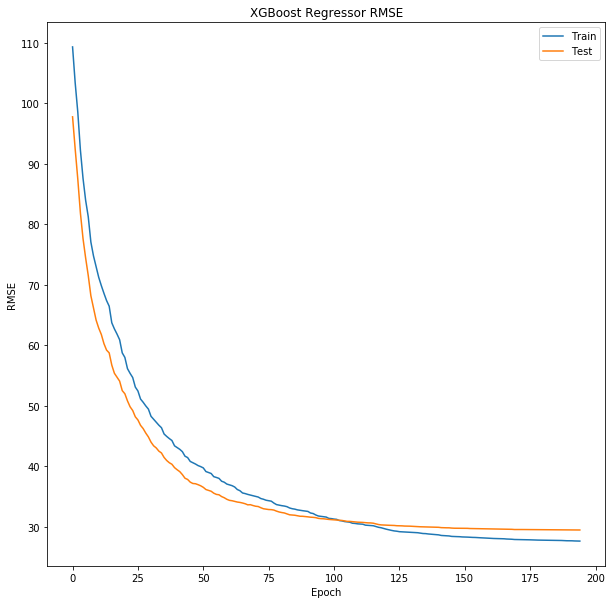

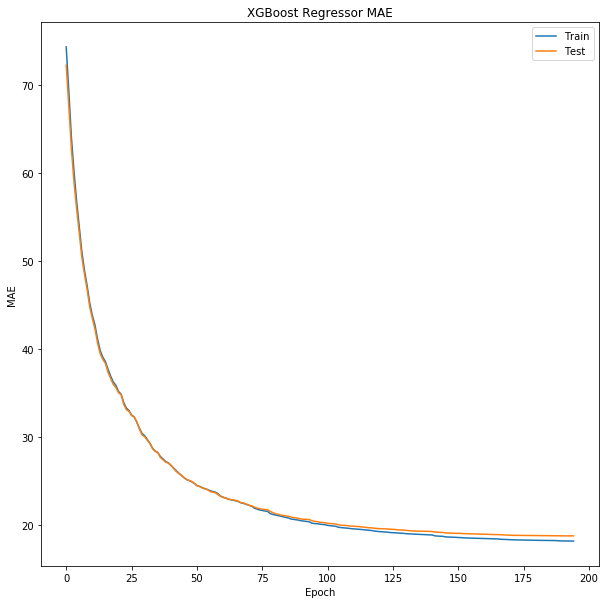

In [20]:
x = XGBRegressor(random_state = 44, n_jobs = 8, n_estimators = 210, max_depth=2, learning_rate=0.15, reg_alpha=0.8, reg_lambda=8, verbosity = 1, objective='reg:squarederror')
eval_set = [(X_train, y_train), (X_test, y_test)]
x.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=eval_set, verbose=False, early_stopping_rounds=5)
print('R2 train score: {0:.2f}'.format(x.score(X_train, y_train)))
predictions = x.predict(X_test)
print('R2 test score: {0:.2f}'.format(x.score(X_test, y_test)))
results = x.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('XGBoost Regressor RMSE')
plt.show()
# plot mae
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('XGBoost Regressor MAE')
plt.show()

<h5><strong>Add prediction column(s) to raw test data</strong></h5>

In [21]:
x = XGBRegressor(random_state = 44, n_jobs = 8, n_estimators = 210, max_depth=2, learning_rate=0.15, reg_alpha=0.8, reg_lambda=8, verbosity = 1, objective='reg:squarederror')
x.fit(X_train, y_train)
print('R2 train score: {0:.2f}'.format(x.score(X_train, y_train)))
LTV_predict = x.predict(train_data)
raw_train['LTV_predict'] = LTV_predict
raw_train['LTV_predict'] = raw_train['LTV_predict'].map(lambda x: int(x)) 
raw_train['LTV_overfit'] = LTV_predict_of
raw_train['LTV_overfit'] = raw_train['LTV_overfit'].map(lambda x: int(x)) 
raw_train.head(10)

R2 train score: 0.94


C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter,LTV,LTV_predict,LTV_overfit
0,3,A,95,OH,48,510,1,1,95,0,android,115,0.16,1,-37,-31,-36
1,4,C,60,CA,195,146,0,2,0,0,iphone,163,0.15,0,-61,-45,-61
2,5,B,80,MO,1,146,1,2,44,0,iphone,127,0.86,0,23,12,22
3,6,A,95,TN,268,98,1,1,0,0,iphone,35,0.90,0,7,15,7
4,7,B,80,TN,129,302,1,1,96,0,iphone,29,0.12,1,118,63,117
5,8,A,95,OH,82,580,2,2,0,0,iphone,104,0.70,0,26,35,26
6,10,C,60,NY,209,669,1,1,26,4,iphone,50,0.36,1,16,-37,15
7,14,B,80,ID,46,1185,2,2,13,3,iphone,50,0.50,0,91,90,91
8,18,A,95,GA,128,191,1,1,98,1,iphone,48,0.32,1,67,55,62
9,20,A,95,MO,89,824,0,2,50,1,android,38,0.81,1,-56,-31,-55


<h5><strong>Add prediction column to blind data</strong></h5>

In [22]:
LTV_predict = x.predict(blind_data)
raw_blind['LTV_predict'] = LTV_predict
# raw_blind['LTV_predict'] = raw_blind['LTV_predict'].map(lambda x: '{0:.0f}'.format(x)) 
raw_blind['LTV_predict'] = raw_blind['LTV_predict'].map(lambda x: int(x)) 
raw_blind.head(10)

,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter,LTV_predict
0,1,B,80,IL,205,657,0,2,17,0,android,56,0.67,1,-96
1,2,C,60,IL,150,179,0,1,0,0,android,10,0.38,0,-181
2,9,B,80,OH,211,580,0,1,0,0,iphone,104,0.51,0,27
3,11,C,60,NY,50,116982,0,1,5,2,android,43,0.54,0,-167
4,12,B,80,NY,37,116,1,1,4,0,android,97,0.38,0,-110
5,13,C,60,NaN,226,1185,0,2,0,3,android,112,0.83,0,-91
6,15,B,80,FL,116,1185,1,1,4,2,android,13,0.81,0,-14
7,16,C,60,NY,97,239,1,1,12,3,iphone,133,0.24,1,-119
8,17,D,75,GA,64,483,1,1,30,0,android,130,0.75,1,-191
9,19,B,80,GA,89,242,0,1,0,1,iphone,38,0.58,0,-2


<h4><strong>Examine feature importance</strong></h4>
<h5>Weight (F-score) is number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees.</h5>

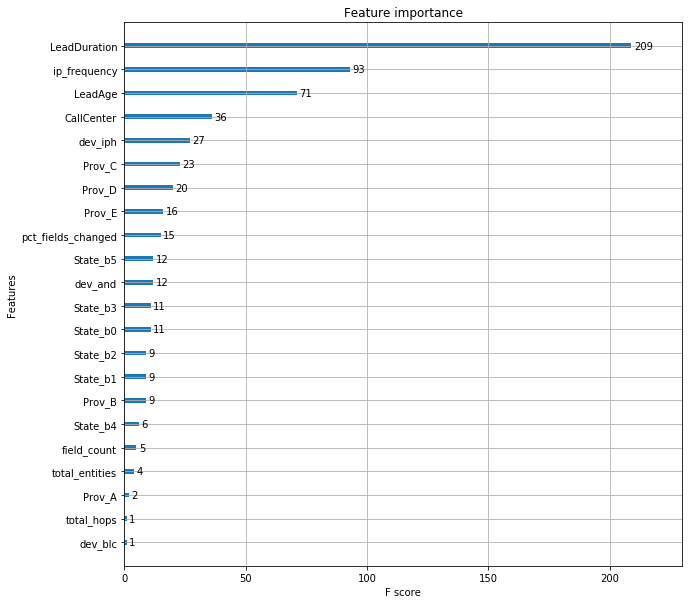

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(x, ax=ax)
plt.show()

<h4><strong>Look at additional importance measures:</strong></h4>
<ol>
<li>Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. <strong>A higher value of this metric when compared to another feature implies it is more important for generating a prediction. </strong>Represents improvement in accuracy brought by a feature to the branches it is on.</li>
<li>Cover metric means the relative number of observations (to decide the leaf node) related to this feature</li>
<li>Weight (or /Frequency) is the number of times a feature is used to split the data across all trees. Same as plot_importance...</li>
</ol>

In [24]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
gain = x.get_booster().get_score(importance_type= 'gain')
total_gain = x.get_booster().get_score(importance_type= 'total_gain')
cover = x.get_booster().get_score(importance_type= 'cover')
total_cover = x.get_booster().get_score(importance_type= 'total_cover')
weight = x.get_booster().get_score(importance_type= 'weight')

In [25]:
g = pd.DataFrame(list(gain.items()), columns=['Feature', 'Gain'])
c = pd.DataFrame(list(cover.items()), columns=['Feature', 'Cover'])
w = pd.DataFrame(list(weight.items()), columns=['Feature', 'Weight'])
c.drop(c.columns[c.columns.isin(g.columns)], axis=1, inplace=True)
w.drop(w.columns[w.columns.isin(g.columns)], axis=1, inplace=True)
importance = pd.concat([g, c, w], axis=1)
importance['log_gain'] =np.log(importance['Gain'])

In [26]:
importance.head(50)

,Feature,Gain,Cover,Weight,log_gain
0,dev_and,2.219599e+06,3707.916667,12,14.612837
1,LeadDuration,4.257401e+05,2705.167464,209,12.961584
2,Prov_C,7.910168e+05,3032.956522,23,13.581074
3,dev_iph,3.168847e+05,2583.444444,27,12.666293
4,Prov_D,2.065584e+05,3194.100000,20,12.238339
5,ip_frequency,4.596114e+04,3178.817204,93,10.735552
6,LeadAge,4.362532e+04,2655.394366,71,10.683393
7,CallCenter,4.680836e+04,2468.777778,36,10.753817
8,Prov_E,9.425551e+04,3399.250000,16,11.453765
9,Prov_B,7.762455e+04,3812.666667,9,11.259639


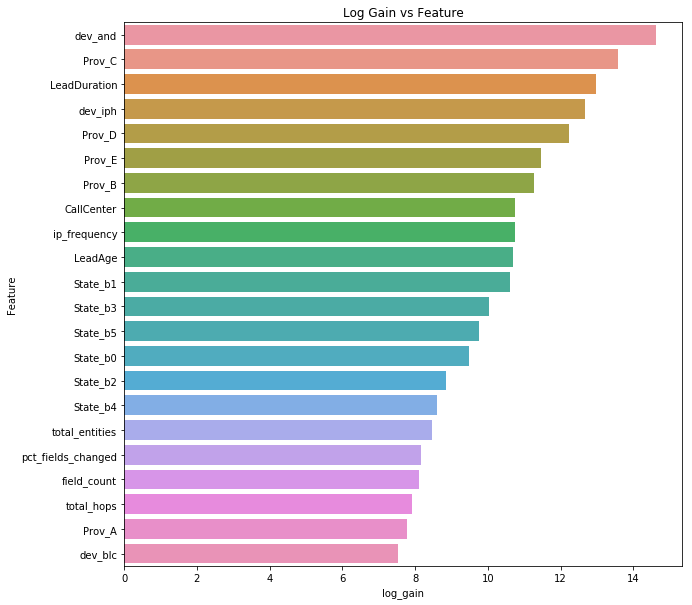

In [27]:
importance.sort_values(by=['log_gain'], inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.title("Log Gain vs Feature")
ax = sns.barplot(y='Feature', x='log_gain', data=importance, orient='h')

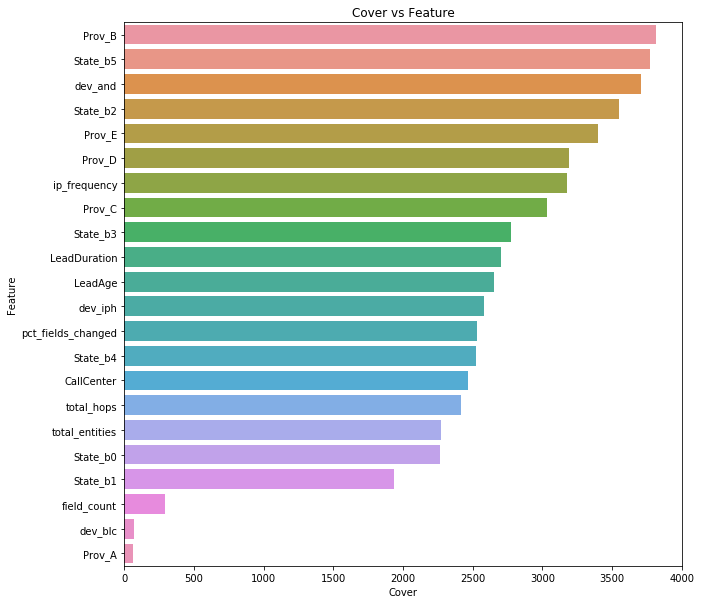

In [28]:
importance.sort_values(by=['Cover'], inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.title("Cover vs Feature")
ax = sns.barplot(y='Feature', x='Cover', data=importance, orient='h')

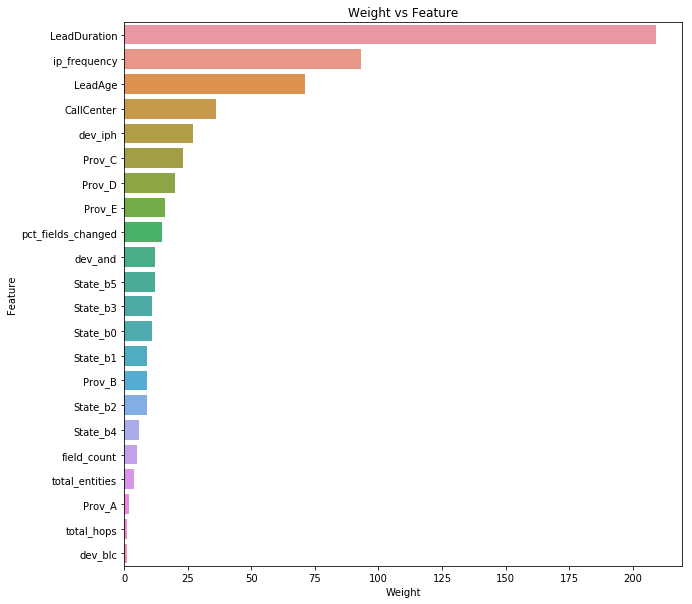

In [29]:
importance.sort_values(by=['Weight'], inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.title("Weight vs Feature")
ax = sns.barplot(y='Feature', x='Weight', data=importance, orient='h')

<h4><strong>Cumulative Gain and Lift for Blind DTC data set</strong></h4>
<h5>Positive Customer Response --> LTV >= 50 </h5>

In [30]:
ltv_threshold = 0
# make two copies of blind data set: (1) for sorted cumulative LTV and (2) unsorted cumulative LTV 
blind_one = raw_blind.copy(deep=True)
blind_two = raw_blind.copy(deep=True)
blind_one['positive_lead'] = np.where(blind_one['LTV_predict'] >= ltv_threshold, 1, 0) 
num = blind_one.positive_lead.sum()
pct = 100.0 * num / len(blind_one)
print('Total Leads: {}, Predicted Positive Leads: {} as percent of total: {:.1f}'.format(len(blind_one), num, pct))
blind_one.head()

Total Leads: 4965, Predicted Positive Leads: 891 as percent of total: 17.9


,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter,LTV_predict,positive_lead
0,1,B,80,IL,205,657,0,2,17,0,android,56,0.67,1,-96,0
1,2,C,60,IL,150,179,0,1,0,0,android,10,0.38,0,-181,0
2,9,B,80,OH,211,580,0,1,0,0,iphone,104,0.51,0,27,1
3,11,C,60,NY,50,116982,0,1,5,2,android,43,0.54,0,-167,0
4,12,B,80,NY,37,116,1,1,4,0,android,97,0.38,0,-110,0


In [31]:
blind_one.sort_values(by=['LTV_predict'], inplace=True, ascending=False)
blind_one['pos_LTV'] = blind_one['LTV_predict'].map(lambda x: x if x >=0 else 0)
blind_one['cum_LTV'] = blind_one['pos_LTV'].cumsum()
blind_one.head()

,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter,LTV_predict,positive_lead,pos_LTV,cum_LTV
4140,8307,B,80,FL,109,13422,0,1,0,0,iphone,50,0.54,0,1431,1,1431,1431
4141,8309,E,100,TX,225,13725,1,1,0,0,android,50,0.16,0,1359,1,1359,2790
3602,7243,C,60,MI,101,10521,0,1,1,0,blackberry,256,0.95,0,1354,1,1354,4144
4259,8550,A,95,FL,8,15896,2,1,0,0,android,25,0.66,0,1345,1,1345,5489
1547,3138,B,80,PA,64,12549,0,1,7915,0,iphone,35,0.76,0,1330,1,1330,6819


In [32]:
blind_two['cum_LTV'] = blind_two['LTV_predict'].cumsum()
blind_two['cum_LTV_mod'] = blind_two['cum_LTV'].map(lambda x: x if x >=0 else 500)
blind_two.head()

,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter,LTV_predict,cum_LTV,cum_LTV_mod
0,1,B,80,IL,205,657,0,2,17,0,android,56,0.67,1,-96,-96,500
1,2,C,60,IL,150,179,0,1,0,0,android,10,0.38,0,-181,-277,500
2,9,B,80,OH,211,580,0,1,0,0,iphone,104,0.51,0,27,-250,500
3,11,C,60,NY,50,116982,0,1,5,2,android,43,0.54,0,-167,-417,500
4,12,B,80,NY,37,116,1,1,4,0,android,97,0.38,0,-110,-527,500


(-500, 1000)

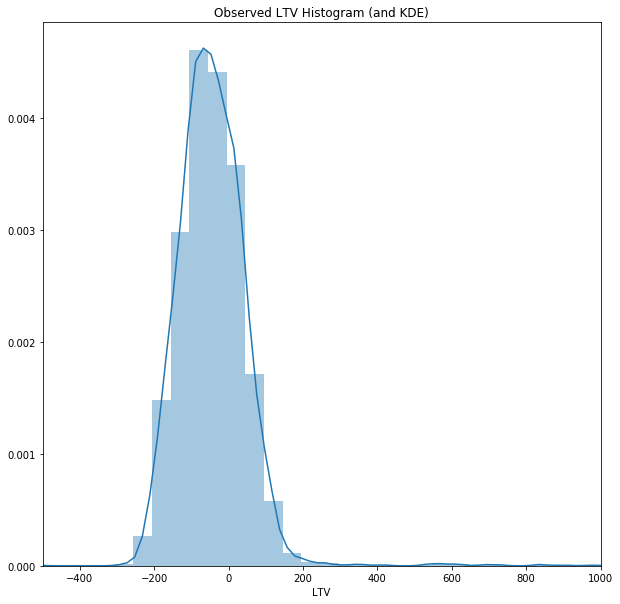

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.title("Observed LTV Histogram (and KDE)")
ax = sns.distplot(raw_train.LTV)
ax.set_xlim([-500,1000])
plt.show()

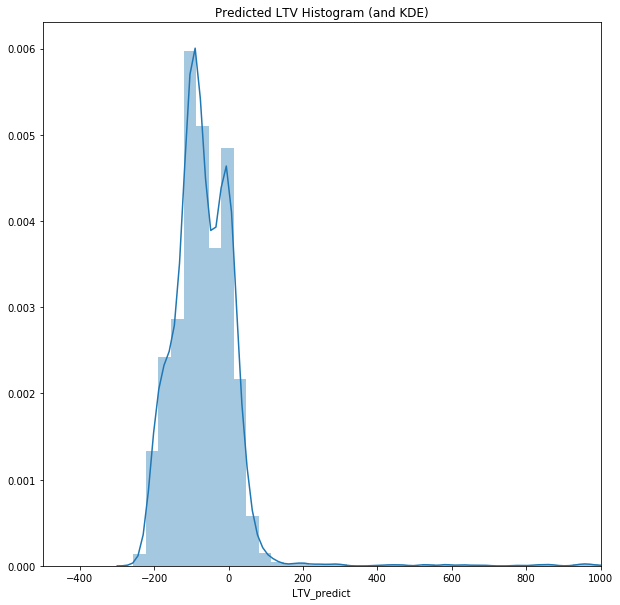

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.title("Predicted LTV Histogram (and KDE)")
ax = sns.distplot(raw_blind.LTV_predict)
ax.set_xlim([-500,1000])
plt.show()

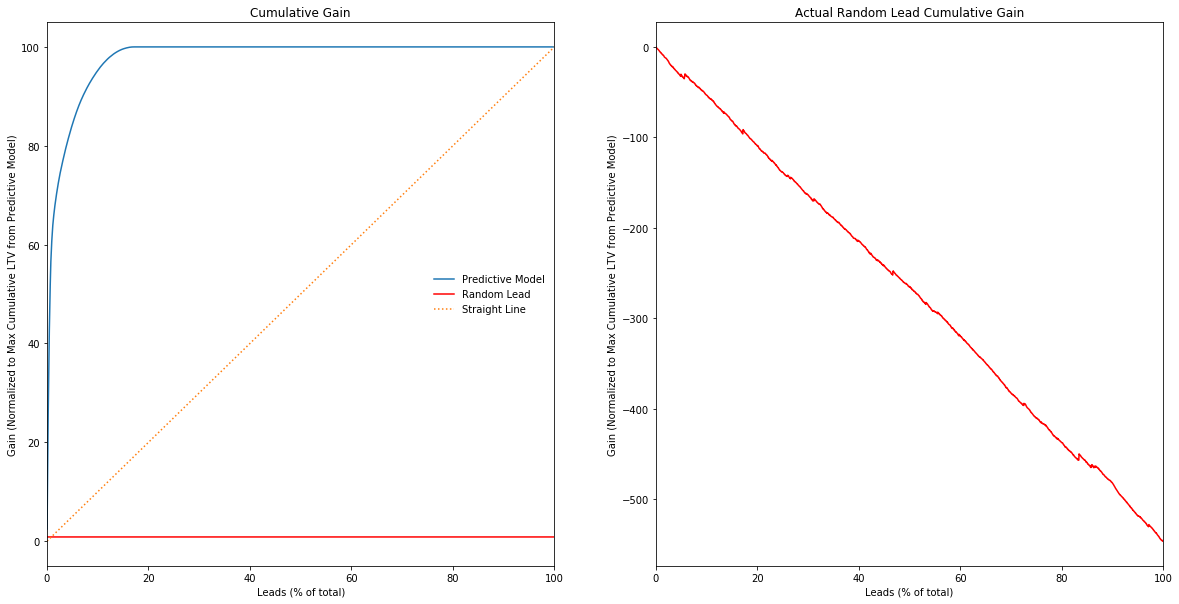

In [35]:
# create cumulative gain plot
ind = 100.0 * np.arange(1, len(blind_one) + 1) / len(blind_one)
max_cum_LTV = blind_one.cum_LTV.max()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(ind, 100.0 * blind_one.cum_LTV / max_cum_LTV, label='Predictive Model')
ax1.plot(ind, 100.0 * blind_two.cum_LTV_mod / max_cum_LTV, label='Random Lead', color="Red")
ax1.plot(ind, ind, ':', label='Straight Line')
ax1.set_title('Cumulative Gain')
ax1.margins(0, 0.05)
ax1.set_xlabel('Leads (% of total)')
ax1.set_ylabel('Gain (Normalized to Max Cumulative LTV from Predictive Model)')
ax1.legend(loc="right", frameon=False)
ax2.set_title('Actual Random Lead Cumulative Gain')
ax2.margins(0, 0.05)
ax2.set_xlabel('Leads (% of total)')
ax2.set_ylabel('Gain (Normalized to Max Cumulative LTV from Predictive Model)')
ax2.plot(ind, 100.0 * blind_two.cum_LTV / max_cum_LTV, label='Random Lead', color='Red')
plt.show()

In [36]:
lift_one = np.divide(blind_one.cum_LTV, blind_two.cum_LTV) 
lift_two = np.divide(100.0 * blind_one.cum_LTV / max_cum_LTV, ind)
base = np.divide(ind, ind)

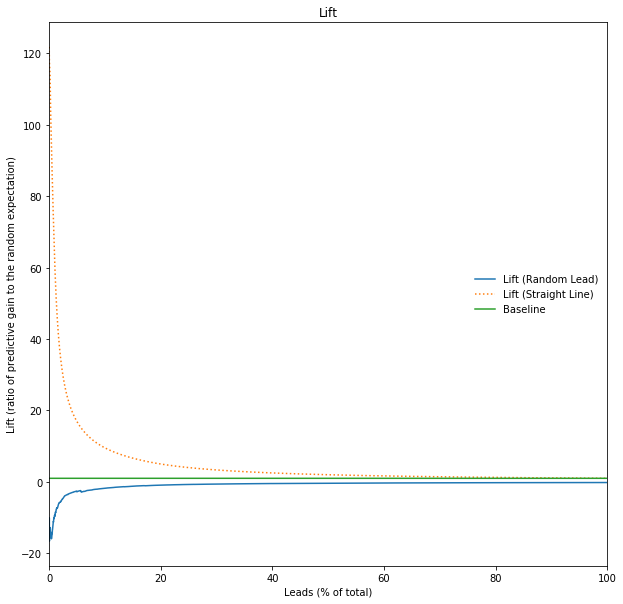

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ind, lift_one, label='Lift (Random Lead)')
ax.plot(ind, lift_two, ':', label='Lift (Straight Line)')
ax.plot(ind, base, label='Baseline')
ax.set_title('Lift')
ax.margins(0, 0.05)
ax.set_xlabel('Leads (% of total)')
ax.set_ylabel('Lift (ratio of predictive gain to the random expectation)')
ax.legend(loc="right", frameon=False)
plt.show()

In [38]:
total_pos_leads_cost = blind_one.loc[blind_one['positive_lead'] == 1, 'Cost'].sum()
A_pos_leads = len(blind_one.loc[(blind_one['positive_lead'] == 1) & (blind_one['Provider'] == 'A')])
B_pos_leads = len(blind_one.loc[(blind_one['positive_lead'] == 1) & (blind_one['Provider'] == 'B')])
C_pos_leads = len(blind_one.loc[(blind_one['positive_lead'] == 1) & (blind_one['Provider'] == 'C')])
D_pos_leads = len(blind_one.loc[(blind_one['positive_lead'] == 1) & (blind_one['Provider'] == 'D')])
E_pos_leads = len(blind_one.loc[(blind_one['positive_lead'] == 1) & (blind_one['Provider'] == 'E')])

print(total_pos_leads_cost, A_pos_leads, B_pos_leads, C_pos_leads, D_pos_leads, E_pos_leads)

75895 270 492 36 23 70


<h4><strong>Lead Buy Recommendations</strong></h4>

In [39]:
raw_blind['BUY'] = 0
raw_blind.loc[(raw_blind.Provider == 'A') & (raw_blind.LTV_predict > 0), 'BUY'] = 1
raw_blind.loc[(raw_blind.Provider == 'B') & (raw_blind.LTV_predict > 0), 'BUY'] = 1
raw_blind.loc[(raw_blind.Provider == 'C') & (raw_blind.LTV_predict > -45.1), 'BUY'] = 1
raw_blind.loc[(raw_blind.Provider == 'D') & (raw_blind.LTV_predict > -46.0), 'BUY'] = 1
raw_blind.loc[(raw_blind.Provider == 'E') & (raw_blind.LTV_predict > 21), 'BUY'] = 1


total_leads_cost = raw_blind.loc[raw_blind['BUY'] == 1, 'Cost'].sum()

A_leads = len(raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'A')])
A_cum_LTV = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'A'), 'LTV_predict'].sum()
A_cost = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'A'), 'Cost'].sum()

B_leads = len(raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'B')])
B_cum_LTV = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'B'), 'LTV_predict'].sum()
B_cost = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'B'), 'Cost'].sum()

C_leads = len(raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'C')])
C_cum_LTV = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'C'), 'LTV_predict'].sum()
C_cost = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'C'), 'Cost'].sum()

D_leads = len(raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'D')])
D_cum_LTV = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'D'), 'LTV_predict'].sum()
D_cost = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'D'), 'Cost'].sum()

E_leads = len(raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'E')])
E_cum_LTV = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'E'), 'LTV_predict'].sum()
E_cost = raw_blind.loc[(raw_blind['BUY'] == 1) & (raw_blind['Provider'] == 'E'), 'Cost'].sum()

print('Recommended Leads for Provider A: {} with cumulative LTV: {} at cost {}'.format(A_leads, A_cum_LTV, A_cost))
print('Recommended Leads for Provider B: {} with cumulative LTV: {} at cost {}'.format(B_leads, B_cum_LTV, B_cost))
print('Recommended Leads for Provider C: {} with cumulative LTV: {} at cost {}'.format(C_leads, C_cum_LTV, C_cost))
print('Recommended Leads for Provider D: {} with cumulative LTV: {} at cost {}'.format(D_leads, D_cum_LTV, D_cost))
print('Recommended Leads for Provider E: {} with cumulative LTV: {} at cost {}'.format(E_leads, E_cum_LTV, E_cost))
print("Total Cost for Recommended Leads", total_leads_cost)

raw_blind.head(500)

Recommended Leads for Provider A: 255 with cumulative LTV: 12793 at cost 24225
Recommended Leads for Provider B: 460 with cumulative LTV: 21951 at cost 36800
Recommended Leads for Provider C: 101 with cumulative LTV: 10957 at cost 6060
Recommended Leads for Provider D: 101 with cumulative LTV: 2972 at cost 7575
Recommended Leads for Provider E: 50 with cumulative LTV: 5322 at cost 5000
Total Cost for Recommended Leads 79660


,LeadiD,Provider,Cost,State,LeadAge,LeadDuration,total_hops,total_entities,ip_frequency,consumer_frequency,device,field_count,pct_fields_changed,CallCenter,LTV_predict,BUY
0,1,B,80,IL,205,657,0,2,17,0,android,56,0.67,1,-96,0
1,2,C,60,IL,150,179,0,1,0,0,android,10,0.38,0,-181,0
2,9,B,80,OH,211,580,0,1,0,0,iphone,104,0.51,0,27,1
3,11,C,60,NY,50,116982,0,1,5,2,android,43,0.54,0,-167,0
4,12,B,80,NY,37,116,1,1,4,0,android,97,0.38,0,-110,0
5,13,C,60,NaN,226,1185,0,2,0,3,android,112,0.83,0,-91,0
6,15,B,80,FL,116,1185,1,1,4,2,android,13,0.81,0,-14,0
7,16,C,60,NY,97,239,1,1,12,3,iphone,133,0.24,1,-119,0
8,17,D,75,GA,64,483,1,1,30,0,android,130,0.75,1,-191,0
9,19,B,80,GA,89,242,0,1,0,1,iphone,38,0.58,0,-2,0
